
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [54]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [55]:
# Read league of legends data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
df = pd.read_csv('../data/league-of-legends/high_diamond_ranked_10min.csv')

In [56]:
# Get Pandas Profiling Report
from pandas_profiling import ProfileReport
ProfileReport(df, minimal=True).to_notebook_iframe()

In [57]:
from sklearn.model_selection import train_test_split

def wrangle(X, target):
    """Wrangle train, validate, and test sets in the same way"""

    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Dropping 'gameId' column due to being unrelated to the outcome of the match
    dropped = ['gameId']
    
    # 'redFirstBlood' is redundant since it will always be the opposite of blueFirstBlood
    dropped.append('redFirstBlood')

    # 'blueDeaths' and 'redDeaths' are redundant since they are the same as 'redKills' and 'blueKills'
    dropped.append('redDeaths')
    dropped.append('blueDeaths')
    
    # 'blueGoldPerMin' and 'redGoldPerMin' are redundant since they are the same as 'blueTotalGold'
    # and 'redTotalGold' divided by 10
    dropped.append('blueGoldPerMin')
    dropped.append('redGoldPerMin')
    
    # 'blueCSPerMin' and 'redCSPerMin' are redundant since they are the same as
    # 'blueTotalMinionsKilled' and 'redblueTotalMinionsKilled' divided by 10
    dropped.append('blueCSPerMin')
    dropped.append('redCSPerMin')
    
    # 'redGoldDiff' is redundant since it will always be the negative of 'blueGoldDiff'
    dropped.append('redGoldDiff')
    
    # 'redExperienceDiff' is redundant since it will always be the negative of 'blueExperienceDiff'
    dropped.append('redExperienceDiff')
    
    X.drop(columns=dropped, inplace=True)
    
    # Split df into train & test. 80/20 split.
    train, test = train_test_split(X, test_size=0.20,
                               stratify=X[target], random_state=42)

    # Split train into train & val. 80/20 split.
    train, val = train_test_split(train, test_size=0.20,
                               stratify=train[target], random_state=42)
    
    # return the wrangled dataframe
    return train, val, test

In [58]:
# Setting target to blueWins
target = 'blueWins'
train, val, test = wrangle(df, target)

In [59]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [60]:
# converting target into a list to find the majority class
# using value_counts(normalize=True) to find the accuracy score
y = y_train.values.tolist()
majority_class = max(set(y), key = y.count)
print(f'Majority Class: {majority_class}')
print(f'Accuracy Score: {y_train.value_counts(normalize=True)[0]:,.2f}')

Majority Class: 0
Accuracy Score: 0.50


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Instantiate model
log = LogisticRegression(random_state=42)

# Fit model on training data
log.fit(X_train, y_train)

# Check performance metric (accuracy) on train, validation, and test sets
print('Training Accuracy:', log.score(X_train, y_train))
print('Validating Accuracy:', log.score(X_val, y_val))

Training Accuracy: 0.7309395760835179
Validating Accuracy: 0.7337128399746996


In [62]:
from sklearn.svm import LinearSVC

lsvc = make_pipeline(
    StandardScaler(), 
    LinearSVC(random_state=42, dual=False)
)

lsvc.fit(X_train, y_train)

print('training accuracy:', lsvc.score(X_train, y_train))
print('validation accuracy:', lsvc.score(X_val, y_val))

training accuracy: 0.7360012654223347
validation accuracy: 0.7229601518026565


In [95]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

print('training accuracy:', rf.score(X_train, y_train))
print('validation accuracy:', rf.score(X_val, y_val))

training accuracy: 1.0
validation accuracy: 0.7160025300442757


In [64]:
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(
    StandardScaler(), 
    DecisionTreeClassifier(random_state=42)
)

tree.fit(X_train, y_train)

print('training accuracy:', tree.score(X_train, y_train))
print('validation accuracy:', tree.score(X_val, y_val))

training accuracy: 1.0
validation accuracy: 0.6375711574952562


In [65]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, n_jobs=-1)

eval_set = [(X_train, y_train,
            X_val, y_val)]

xgb.fit(X_train, y_train, eval_set=eval_set,
        eval_metric='error', early_stopping_rounds=50)

print('training accuracy:', xgb.score(X_train, y_train))
print('validation accuracy:', xgb.score(X_val, y_val))

[0]	validation_0-error:0.272382
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.272382
[2]	validation_0-error:0.267479
[3]	validation_0-error:0.264157
[4]	validation_0-error:0.267479
[5]	validation_0-error:0.267162
[6]	validation_0-error:0.262575
[7]	validation_0-error:0.26305
[8]	validation_0-error:0.261942
[9]	validation_0-error:0.26131
[10]	validation_0-error:0.261468
[11]	validation_0-error:0.260519
[12]	validation_0-error:0.258621
[13]	validation_0-error:0.257197
[14]	validation_0-error:0.259095
[15]	validation_0-error:0.258304
[16]	validation_0-error:0.258304
[17]	validation_0-error:0.25783
[18]	validation_0-error:0.257355
[19]	validation_0-error:0.256564
[20]	validation_0-error:0.256881
[21]	validation_0-error:0.256564
[22]	validation_0-error:0.255141
[23]	validation_0-error:0.255457
[24]	validation_0-error:0.255615
[25]	validation_0-error:0.255457
[26]	validation_0-error:0.255457
[27]	validation_0-error:0.254983
[28]	validation_0-error

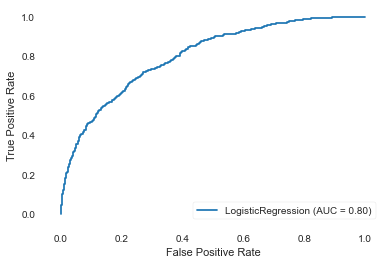

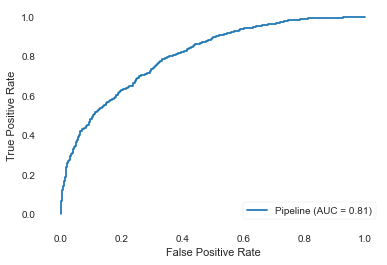

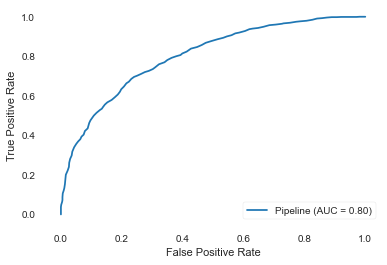

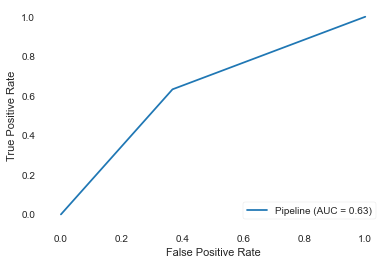

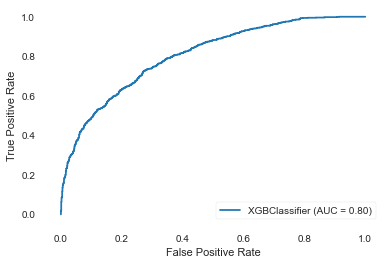

In [66]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(log, X_test, y_test)
plot_roc_curve(lsvc, X_test, y_test)
plot_roc_curve(rf, X_test, y_test)
plot_roc_curve(tree, X_test, y_test)
plot_roc_curve(xgb, X_test, y_test)

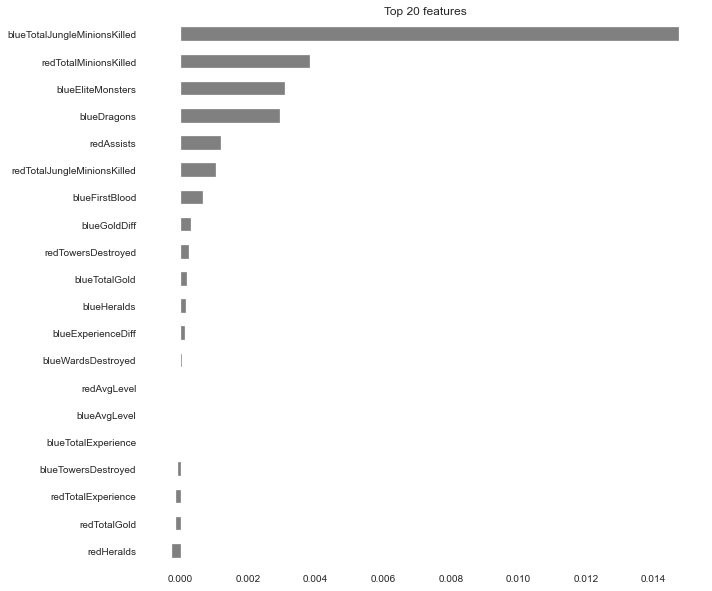

In [70]:
# Get feature importances
importances = pd.Series(log.coef_[0], X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [71]:
feature = 'blueGoldDiff'
X_val[feature].value_counts()

-833     4
-1208    4
 2588    3
-498     3
-736     3
        ..
-1276    1
 3324    1
 1279    1
-3330    1
 0       1
Name: blueGoldDiff, Length: 1442, dtype: int64

In [72]:
X_val_shuffled = X_val.copy()

In [73]:
X_val[feature].head()

9625   -2395
4652    1952
5732   -3983
964     1991
2908    -726
Name: blueGoldDiff, dtype: int64

In [74]:
X_val_shuffled[feature] = np.random.permutation(X_val[feature])

In [75]:
X_val_shuffled[feature].head()

9625    2877
4652    1323
5732   -3608
964      956
2908    1433
Name: blueGoldDiff, dtype: int64

In [76]:
score_with = log.score(X_val, y_val)
score_permuted = log.score(X_val_shuffled, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with blueGoldDiff: 0.7337128399746996
Validation Accuracy with blueGoldDiff permuted: 0.6261859582542695
Permutation Importance: 0.10752688172043012


In [77]:
from sklearn.inspection import permutation_importance

In [78]:
result = permutation_importance(log, X_val, y_val,
                                n_repeats=5, random_state=42)

In [79]:
df = pd.DataFrame({'feature': X_val.columns,
                  'importances_mean': np.round(result['importances_mean'], 3),
                  'importances_std': result['importances_std']})

In [80]:
df.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
14,blueGoldDiff,0.093,0.006027
9,blueTotalGold,0.015,0.002951
15,blueExperienceDiff,0.010,0.005361
13,blueTotalJungleMinionsKilled,0.006,0.003569
27,redTotalMinionsKilled,0.005,0.001362
26,redTotalExperience,0.005,0.003940
12,blueTotalMinionsKilled,0.004,0.002227
24,redTotalGold,0.003,0.004867
0,blueWardsPlaced,0.002,0.000759
28,redTotalJungleMinionsKilled,0.002,0.000645


In [81]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    log,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val, y_val)

PermutationImportance(estimator=LogisticRegression(random_state=42),
                      random_state=42, scoring='accuracy')

In [82]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.0856 ± 0.0201,blueGoldDiff
0.0167 ± 0.0061,blueTotalGold
0.0149 ± 0.0089,blueExperienceDiff
0.0062 ± 0.0042,redTotalGold
0.0057 ± 0.0095,blueTotalJungleMinionsKilled
0.0056 ± 0.0056,redTotalMinionsKilled
0.0039 ± 0.0097,redTotalExperience
0.0024 ± 0.0046,blueTotalMinionsKilled
0.0019 ± 0.0016,redTotalJungleMinionsKilled
0.0010 ± 0.0006,blueKills


In [83]:
# When including matplotlib images in my blog post or web apps,
# increase the dpi, so the text isn't so fuzzy. Potentially double it.
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [84]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'blueGoldDiff'

isolated = pdp_isolate(
    model=log,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='blueGoldDiff'>})

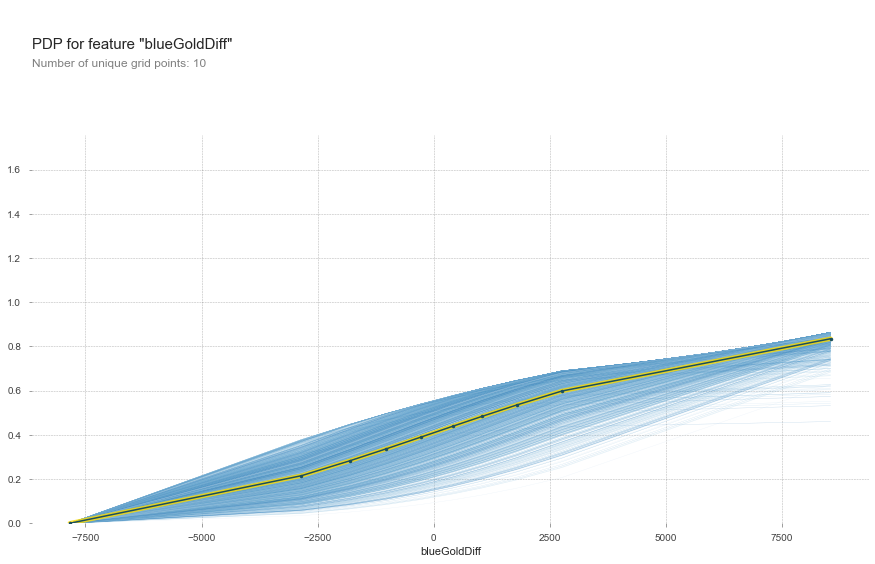

In [85]:
pdp_plot(isolated, feature_name=feature, plot_lines=True)

In [86]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['blueGoldDiff', 'blueTotalGold']

interaction = pdp_interact(
    model=log,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='blueGoldDiff', ylabel='blueTotalGold'>})

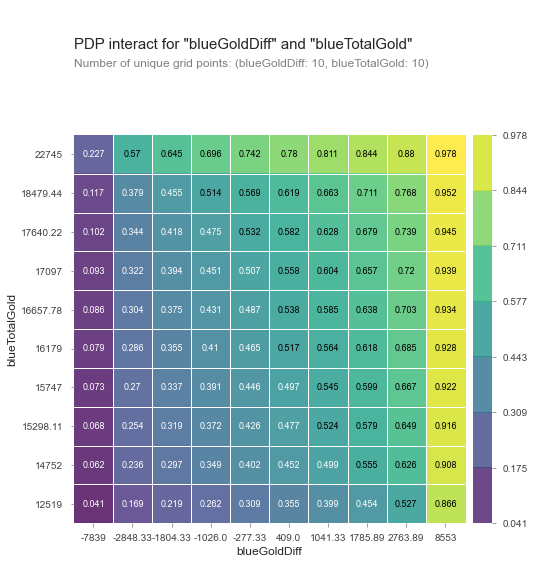

In [87]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [121]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.80309	validation_1-auc:0.788933
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.808115	validation_1-auc:0.796135
[2]	validation_0-auc:0.810781	validation_1-auc:0.797396
[3]	validation_0-auc:0.812388	validation_1-auc:0.79935
[4]	validation_0-auc:0.812788	validation_1-auc:0.800235
[5]	validation_0-auc:0.81393	validation_1-auc:0.799897
[6]	validation_0-auc:0.814583	validation_1-auc:0.800091
[7]	validation_0-auc:0.815382	validation_1-auc:0.801418
[8]	validation_0-auc:0.815475	validation_1-auc:0.801273
[9]	validation_0-auc:0.816113	validation_1-auc:0.802598
[10]	validation_0-auc:0.816481	validation_1-auc:0.802806
[11]	validation_0-auc:0.817037	validation_1-auc:0.802989
[12]	validation_0-auc:0.817396	validation_1-auc:0.802884
[13]	validation_0-auc:0.817859	validation_1-auc:0.803209
[14]	validation_0-auc:0.818382	validation_1-auc:0.803223
[

XGBClassifier(n_estimators=1000, n_jobs=-1)

In [122]:
# THIS CELL ISN'T ABOUT THE NEW OBJECTIVES FOR TODAY
# BUT IT IS IMPORTANT FOR YOUR SPRINT CHALLENGE

from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.8052487348126294


In [123]:
# STUDY/PRACTICE THIS CELL FOR THE SPRINT CHALLENGE
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)